#### <b> Import Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import timedelta
from pywaffle import Waffle
from matplotlib.lines import Line2D
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

#### <b> Read the csv cleaned files submitted in Sprint 1

In [205]:
root_folder = '/Users/shrutik/Desktop/Datathon-June2025/SPRINT-1'

bioGutMicrobeData_df = pd.read_csv(os.path.join(root_folder, '02DataExplorers_Cleaned_MergedBioGuthealthMicrobesData.csv'))
cgmData_df = pd.read_csv(os.path.join(root_folder, '02DataExplorers_Cleaned_Merged_Participants_Data.csv'))

#### <b> This block contains the central logic for calculating the post meal 60 min timestamp, categorizing the physical activity levels based on active calories, calculating the protein/fat/fibre to carb ratios for macronutrient impact on glucose levels, along with getting the HbA1c and BMI classifications.

In [231]:

# Filter only meal entries (non-null carbs + timestamp), and make an explicit copy
meal_df = cgmData_df.dropna(subset=['Carbs', 'Timestamp']).copy()

# Ensure timestamp is in datetime format 
meal_df.loc[:, 'Timestamp'] = pd.to_datetime(meal_df['Timestamp'])

# For each meal, get post-60min Dexcom GL reading
meal_df.loc[:, 'Post60_Timestamp'] = meal_df['Timestamp'] + pd.Timedelta(minutes=60)

# Merge original and future Dexcom values (closest match)
dex_df = cgmData_df[['ParticipantID', 'Timestamp', 'Dexcom_GL']].copy()
dex_df.rename(columns={'Timestamp': 'Post60_Timestamp', 'Dexcom_GL': 'Dexcom_GL_60min'}, inplace=True)

meal_df['Post60_Timestamp'] = pd.to_datetime(meal_df['Post60_Timestamp'])
dex_df['Post60_Timestamp'] = pd.to_datetime(dex_df['Post60_Timestamp'])

# Merge to find 60 min later reading
meal_merged = pd.merge_asof(
    meal_df.sort_values('Post60_Timestamp'),
    dex_df.sort_values('Post60_Timestamp'),
    on='Post60_Timestamp',
    by='ParticipantID',
    direction='forward'
)

# Calculate glucose delta at 60 mins
meal_merged['Dexcom_GL_Delta_60min'] = meal_merged['Dexcom_GL_60min'] - meal_merged['Dexcom_GL']

# Create a macro balance score (example: normalize macros by total meal calories or carbs)
meal_merged['Protein_to_Carb_Ratio'] = meal_merged['Protein'] / (meal_merged['Carbs'] + 1)
meal_merged['Fat_to_Carb_Ratio'] = meal_merged['Fat'] / (meal_merged['Carbs'] + 1)
meal_merged['Fiber_to_Carb_Ratio'] = meal_merged['Fiber'] / (meal_merged['Carbs'] + 1)

# Physical activity
cgmData_df['Timestamp'] = pd.to_datetime(cgmData_df['Timestamp'])
# Calculate average activity (Activity_Calories_Per_Minute) from 0 to 60 minutes post meal
def compute_avg_activity(row):
    pid = row['ParticipantID']
    t_start = row['Timestamp']
    t_end = row['Post60_Timestamp']
    
    activity_window = cgmData_df[
        (cgmData_df['ParticipantID'] == pid) &
        (cgmData_df['Timestamp'] >= t_start) &
        (cgmData_df['Timestamp'] <= t_end)
    ]
    
    return activity_window['Activity_Calories_Per_Minute'].mean()

meal_merged['Avg_Activity_Cal_Per_Min'] = meal_merged.apply(compute_avg_activity, axis=1)

# Categorize into activity levels
def classify_activity_level(value):
    if pd.isnull(value): return 'Unknown'
    elif value < 1.5: return 'Low'
    elif value < 3.0: return 'Moderate'
    else: return 'High'

meal_merged['Activity_Level'] = meal_merged['Avg_Activity_Cal_Per_Min'].apply(classify_activity_level)

# Merge with bioGutMicrobeData_df for HbA1c classification data
meal_HbA1c_df = meal_merged.merge(bioGutMicrobeData_df[['ParticipantID', 'HbA1c_Classification']], on='ParticipantID', how='left')

# Merge with bioGutMicrobeData_df for BMI classification data
meal_bmi_df = meal_merged.merge(bioGutMicrobeData_df[['ParticipantID', 'BMI_Classification']], on='ParticipantID', how='left')


In [211]:
meal_HbA1c_df

,ParticipantID,Timestamp,Date,Time,Libre_GL,Dexcom_GL,Heart_Rate,Activity_Calories_Per_Minute,METs,Meal_Type,...,Image_Path,Post60_Timestamp,Dexcom_GL_60min,Dexcom_GL_Delta_60min,Protein_to_Carb_Ratio,Fat_to_Carb_Ratio,Fiber_to_Carb_Ratio,Avg_Activity_Cal_Per_Min,Activity_Level,HbA1c_Classification
0,2,2019-11-16 10:03:00,11/16/2019,10:03,73.20,103.8,82.0,0.93,10.0,Breakfast,...,photos/00000008-PHOTO-2019-11-16-10-3-0.jpg,2019-11-16 11:03:00,170.8,67.0,0.328358,0.156716,0.000000,2.521311,Moderate,Normal
1,2,2019-11-16 13:27:00,11/16/2019,13:27,40.00,67.8,81.0,1.02,11.0,Lunch,...,photos/00000011-PHOTO-2019-11-16-13-27-0.jpg,2019-11-16 14:27:00,128.4,60.6,0.182796,0.451613,0.107527,1.450328,Low,Normal
2,2,2019-11-16 15:21:00,11/16/2019,15:21,89.80,125.0,81.0,0.93,10.0,Snack,...,photos/00000013-PHOTO-2019-11-16-15-21-0.jpg,2019-11-16 16:21:00,131.4,6.4,7.000000,0.000000,2.000000,1.231475,Low,Normal
3,2,2019-11-16 17:14:00,11/16/2019,17:14,65.40,94.0,87.0,1.12,12.0,Dinner,...,photos/00000015-PHOTO-2019-11-16-17-14-0.jpg,2019-11-16 18:14:00,109.0,15.0,0.437500,0.666667,0.083333,1.857541,Moderate,Normal
4,2,2019-11-16 19:18:00,11/16/2019,19:18,82.40,116.6,77.0,0.93,10.0,Snack,...,photos/00000018-PHOTO-2019-11-16-19-18-0.jpg,2019-11-16 20:18:00,167.0,50.4,0.148148,0.259259,0.000000,1.419508,Low,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701,47,2025-11-07 11:07:00,11/7/2025,11:07,144.80,180.4,65.0,2.58,24.0,Lunch,...,photos/00000054-PHOTO-2025-11-7-11-7-0.jpg,2025-11-07 12:07:00,199.6,19.2,0.454545,0.454545,0.295455,1.601803,Moderate,Diabetes
1702,47,2025-11-07 15:50:00,11/7/2025,15:50,144.27,148.8,71.0,2.58,24.0,Dinner,...,photos/00000056-PHOTO-2025-11-7-15-50-0.jpg,2025-11-07 16:50:00,182.2,33.4,0.677419,0.451613,0.064516,1.580984,Moderate,Diabetes
1703,47,2025-11-08 09:59:00,11/8/2025,9:59,209.33,242.8,107.0,4.73,44.0,Breakfast,...,photos/00000058-PHOTO-2025-11-8-9-59-0.jpg,2025-11-08 10:59:00,183.4,-59.4,0.880000,0.420000,0.000000,5.357049,High,Diabetes
1704,47,2025-11-08 11:28:00,11/8/2025,11:28,153.00,171.4,83.0,1.29,12.0,Lunch,...,photos/00000060-PHOTO-2025-11-8-11-28-0.jpg,2025-11-08 12:28:00,184.2,12.8,0.463158,0.210526,0.042105,2.561803,Moderate,Diabetes


#### <b> Carbs vs Dexcom GL (60-min post-meal) by Meal Type 

<Figure size 1000x600 with 0 Axes>

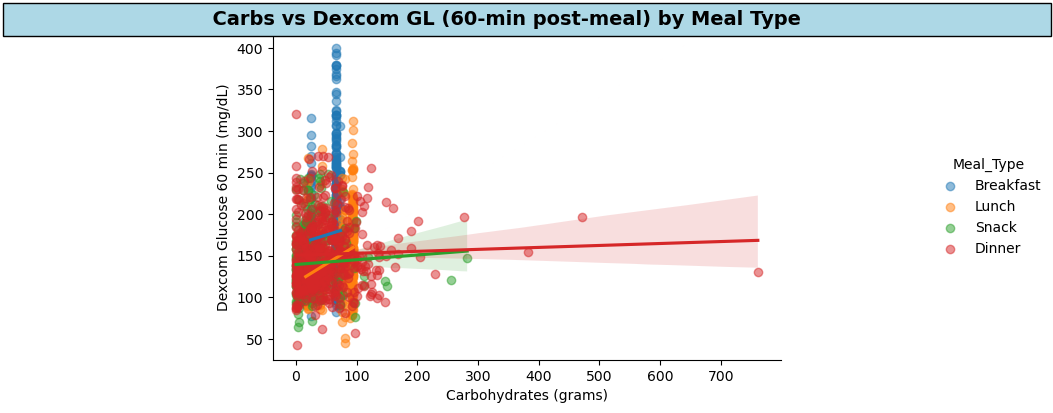

In [394]:
# Visualization 1: Get Data by Meal Type 
plt.figure(figsize=(10, 6))
sns.lmplot(data=meal_merged, x='Carbs', y='Dexcom_GL_60min', hue='Meal_Type', height=4, aspect=1.5, scatter_kws={'alpha':0.5})
plt.title("Carbs vs Dexcom GL (60-min post-meal) by Meal Type")
plt.title('                              Carbs vs Dexcom GL (60-min post-meal) by Meal Type                                    ',
        fontsize=14,
        weight='bold',
        bbox=dict(facecolor='lightblue', 
        pad=5 
        ))
plt.xlabel("Carbohydrates (grams)")
plt.ylabel("Dexcom Glucose 60 min (mg/dL)")
plt.show()

#### <b> Carbs vs Dexcom GL (60-min post-meal) by HbA1c Classification

<Figure size 200x100 with 0 Axes>

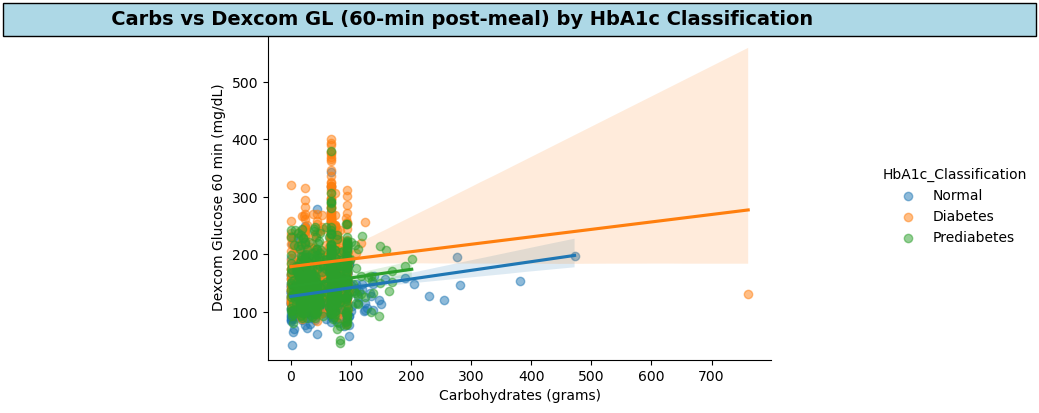

In [396]:

# Visualization 2: Get data by HbA1c Classification 
plt.figure(figsize=(2, 1))
sns.lmplot(data=meal_HbA1c_df, x='Carbs', y='Dexcom_GL_60min', hue='HbA1c_Classification', height=4, aspect=1.5, scatter_kws={'alpha':0.5})
plt.title("Carbs vs Dexcom GL (60-min post-meal) by HbA1c Classification")
plt.title('               Carbs vs Dexcom GL (60-min post-meal) by HbA1c Classification                                ',
        fontsize=14,
        weight='bold',
        bbox=dict(facecolor='lightblue', 
        pad=5 
        ))
plt.xlabel("Carbohydrates (grams)")
plt.ylabel("Dexcom Glucose 60 min (mg/dL)")
plt.show()

#### <b> Protein-to-Carb Ratio vs Glucose Rise 60 min Post Meal

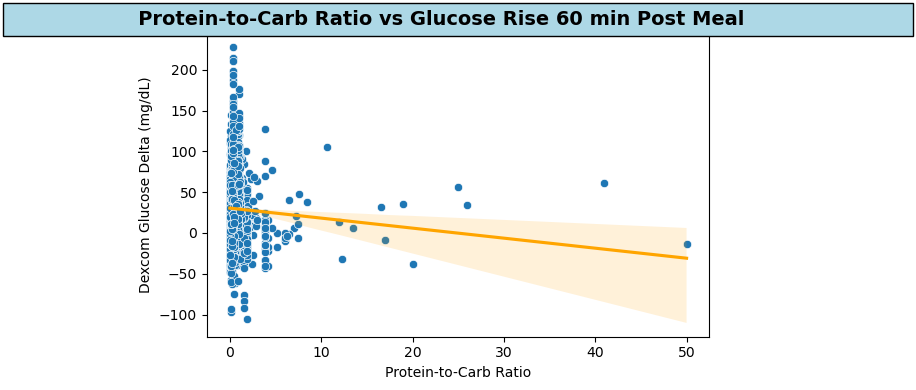

In [398]:
# Visualization 3: Plot for Protein to Carb
plt.figure(figsize=(6, 4))
sns.scatterplot(data=meal_merged, x='Protein_to_Carb_Ratio', y='Dexcom_GL_Delta_60min')
sns.regplot(data=meal_merged, x='Protein_to_Carb_Ratio', y='Dexcom_GL_Delta_60min', scatter=False, color='orange')
plt.title('                   Protein-to-Carb Ratio vs Glucose Rise 60 min Post Meal                        ',
        fontsize=14,
        weight='bold',
        bbox=dict(facecolor='lightblue', 
        pad=5 
        ))
plt.xlabel('Protein-to-Carb Ratio')
plt.ylabel('Dexcom Glucose Delta (mg/dL)')
plt.tight_layout()
plt.show()

#### <b> Fat-to-Carb Ratio vs Glucose Rise 60 min Post Meal

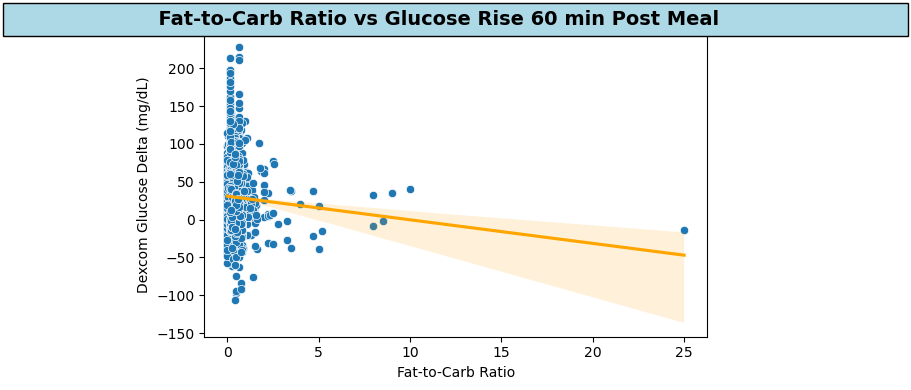

In [400]:
# Visualization 4: Plot for Fat to Carb
plt.figure(figsize=(6, 4))
sns.scatterplot(data=meal_merged, x='Fat_to_Carb_Ratio', y='Dexcom_GL_Delta_60min')
sns.regplot(data=meal_merged, x='Fat_to_Carb_Ratio', y='Dexcom_GL_Delta_60min', scatter=False, color='orange')
plt.title('                      Fat-to-Carb Ratio vs Glucose Rise 60 min Post Meal                           ',
        fontsize=14,
        weight='bold',
        bbox=dict(facecolor='lightblue', 
        pad=5 
        ))
plt.xlabel('Fat-to-Carb Ratio')
plt.ylabel('Dexcom Glucose Delta (mg/dL)')
plt.tight_layout()
plt.show()

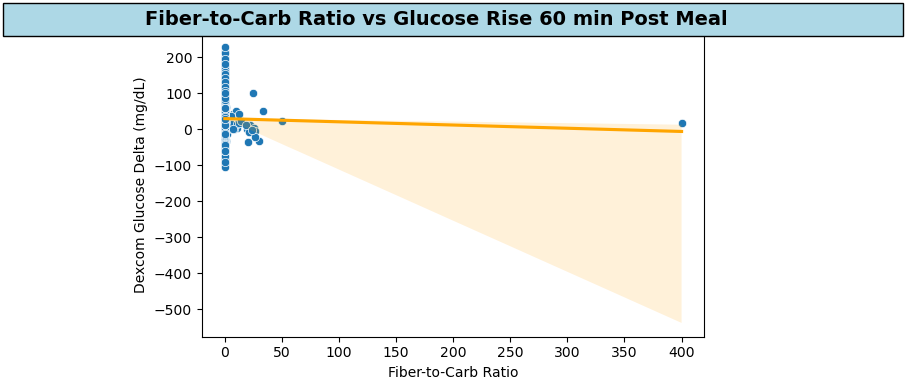

In [402]:
# Visualization 5: Plot for Fiber to Carb
plt.figure(figsize=(6, 4))
sns.scatterplot(data=meal_merged, x='Fiber_to_Carb_Ratio', y='Dexcom_GL_Delta_60min')
sns.regplot(data=meal_merged, x='Fiber_to_Carb_Ratio', y='Dexcom_GL_Delta_60min', scatter=False, color='orange')

plt.title('                    Fiber-to-Carb Ratio vs Glucose Rise 60 min Post Meal                         ',
        fontsize=14,
        weight='bold',
        bbox=dict(facecolor='lightblue', 
        pad=5 
        ))
plt.xlabel('Fiber-to-Carb Ratio')
plt.ylabel('Dexcom Glucose Delta (mg/dL)')
plt.tight_layout()
plt.show()

#### <b> Ethnicity Distribution of Participants

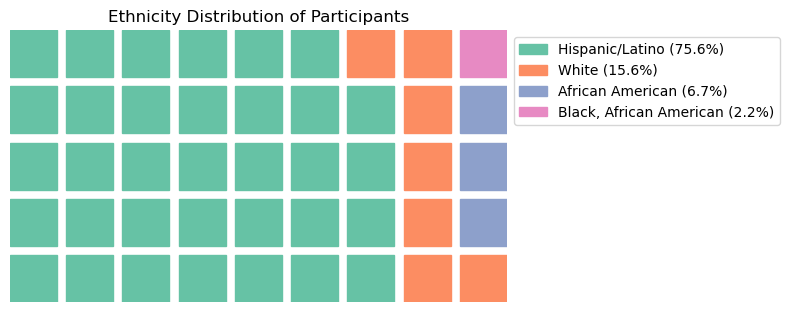

In [345]:
# Count participants by ethnicity
ethnicity_counts = bioGutMicrobeData_df['Ethnicity'].value_counts().dropna()


# Calculate total for percentage conversion
total = ethnicity_counts.sum()

# Create label with percentage
labels = [f"{k} ({(v / total) * 100:.1f}%)" for k, v in ethnicity_counts.items()]

# Create waffle chart
fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=ethnicity_counts,
    labels=labels,
    title={'label': 'Ethnicity Distribution of Participants', 'loc': 'center'},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    figsize=(8, 6)
)

plt.tight_layout()
plt.show()

#### <b> BMI vs HbA1c Classification

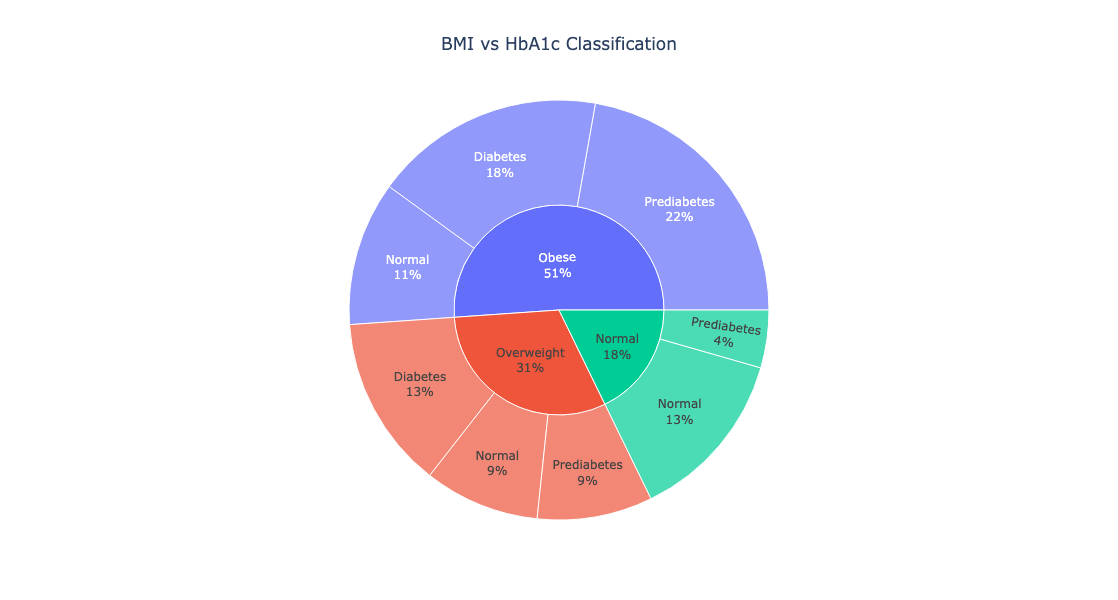

In [225]:

# Drop rows with missing classification data
clean_df = bioGutMicrobeData_df.dropna(subset=["BMI_Classification", "HbA1c_Classification"])

# Group by BMI and HbA1c classification
bmi_hba1c = clean_df.groupby(["BMI_Classification", "HbA1c_Classification"]).size().reset_index(name="Count")

# Create sunburst chart
fig = px.sunburst(
    bmi_hba1c,
    path=["BMI_Classification", "HbA1c_Classification"],
    values="Count",
    title="BMI vs HbA1c Classification"
)

# Show labels and values directly on the chart
fig.update_traces(textinfo="label+percent entry")

fig.update_layout(
    title_x=0.5,
    width=600,
    height=600
)
fig.show()

#### <b> Impact of physical activity levels on glucose spike

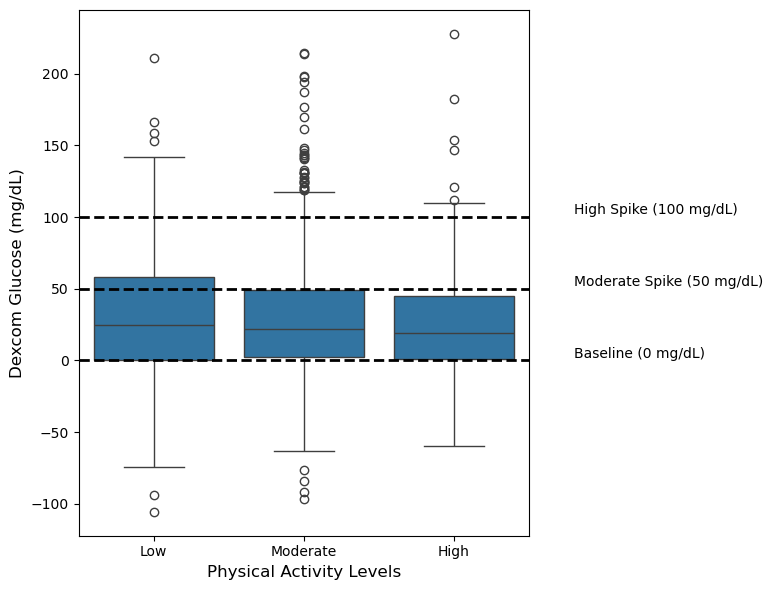

In [365]:
# Create a box-plot for visualizing activity level impact on glucose levels
plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=meal_merged, x='Activity_Level', y='Dexcom_GL_Delta_60min', order=['Low', 'Moderate', 'High'])

# Horizontal reference lines
for y, label in zip([0, 50, 100], ['Baseline (0 mg/dL)', 'Moderate Spike (50 mg/dL)', 'High Spike (100 mg/dL)']):
    ax.axhline(y, color='black', linestyle='--', linewidth=2)
    ax.text(2.8, y + 2, label, color='black', fontsize=10)

# Add labels and title
#plt.title('Impact of Physical Activity on Glucose Spike (0–60 mins)', fontsize=14, weight='bold')
plt.xlabel('Physical Activity Levels', fontsize=12)
plt.ylabel('Dexcom Glucose (mg/dL)', fontsize=12)
plt.tight_layout()
plt.show()

In [151]:
meal_HbA1c_df.head()

,ParticipantID,Timestamp,Date,Time,Libre_GL,Dexcom_GL,Heart_Rate,Activity_Calories_Per_Minute,METs,Meal_Type,...,Fat,Fiber,Amount_Consumed(%),Image_Path,Post60_Timestamp,Dexcom_GL_60min,Dexcom_GL_Delta_60min,Protein_to_Carb_Ratio,Fat_to_Carb_Ratio,HbA1c_Classification
0,2,2019-11-16 10:03:00,11/16/2019,10:03,73.2,103.8,82.0,0.93,10.0,Breakfast,...,10.5,0.0,100.0,photos/00000008-PHOTO-2019-11-16-10-3-0.jpg,2019-11-16 11:03:00,170.8,67.0,0.328358,0.156716,Normal
1,2,2019-11-16 13:27:00,11/16/2019,13:27,40.0,67.8,81.0,1.02,11.0,Lunch,...,42.0,10.0,100.0,photos/00000011-PHOTO-2019-11-16-13-27-0.jpg,2019-11-16 14:27:00,128.4,60.6,0.182796,0.451613,Normal
2,2,2019-11-16 15:21:00,11/16/2019,15:21,89.8,125.0,81.0,0.93,10.0,Snack,...,0.0,2.0,100.0,photos/00000013-PHOTO-2019-11-16-15-21-0.jpg,2019-11-16 16:21:00,131.4,6.4,7.000000,0.000000,Normal
3,2,2019-11-16 17:14:00,11/16/2019,17:14,65.4,94.0,87.0,1.12,12.0,Dinner,...,32.0,4.0,100.0,photos/00000015-PHOTO-2019-11-16-17-14-0.jpg,2019-11-16 18:14:00,109.0,15.0,0.437500,0.666667,Normal
4,2,2019-11-16 19:18:00,11/16/2019,19:18,82.4,116.6,77.0,0.93,10.0,Snack,...,7.0,0.0,100.0,photos/00000018-PHOTO-2019-11-16-19-18-0.jpg,2019-11-16 20:18:00,167.0,50.4,0.148148,0.259259,Normal


#### <b> Impact of physical activity levels on glucose spike By HbA1c classification

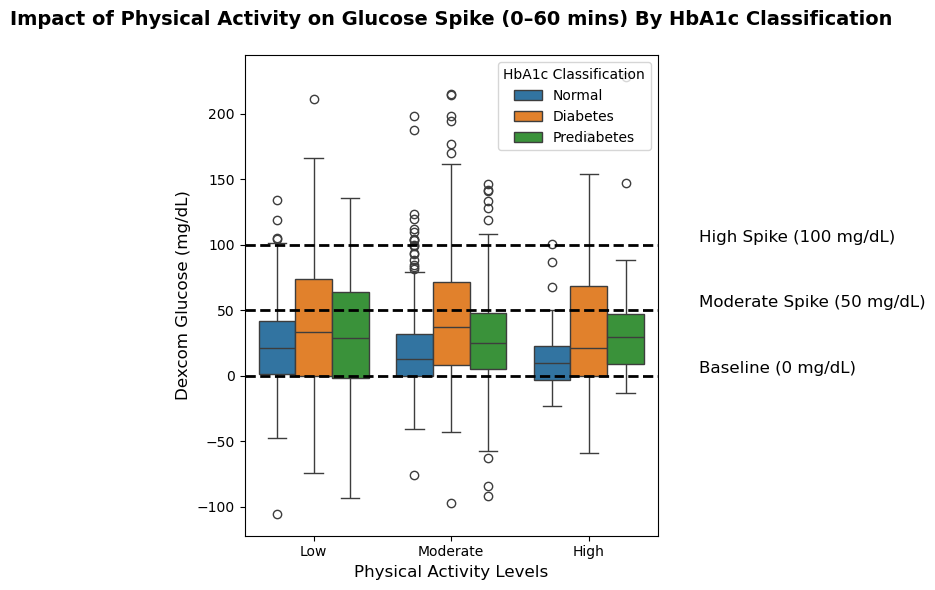

In [408]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    data=meal_HbA1c_df,
    x='Activity_Level',
    y='Dexcom_GL_Delta_60min',
    hue='HbA1c_Classification',
    order=['Low', 'Moderate', 'High']
)

# Add reference lines
for y, label in zip([0, 50, 100], ['Baseline (0 mg/dL)', 'Moderate Spike (50 mg/dL)', 'High Spike (100 mg/dL)']):
    ax.axhline(y, color='black', linestyle='--', linewidth=2)
    ax.text(2.8, y + 2, label, color='black', fontsize=12)

# Style and display
plt.title('Impact of Physical Activity on Glucose Spike (0–60 mins) By HbA1c Classification\n', fontsize=14, weight='bold')
plt.xlabel('Physical Activity Levels', fontsize=12)
plt.ylabel('Dexcom Glucose (mg/dL)', fontsize=12)
plt.legend(title='HbA1c Classification', loc='upper right')
plt.tight_layout()
plt.show()

#### <b> Impact of physical activity levels on glucose spike By BMI classification

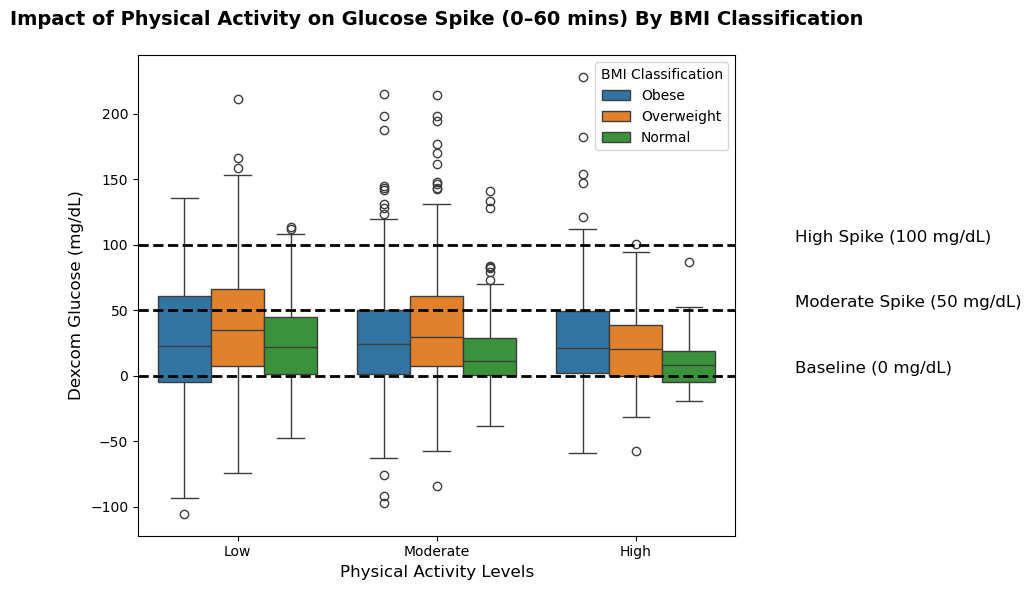

In [414]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=meal_bmi_df,
    x='Activity_Level',
    y='Dexcom_GL_Delta_60min',
    hue='BMI_Classification',
    order=['Low', 'Moderate', 'High']
)

# Add reference lines
for y, label in zip([0, 50, 100], ['Baseline (0 mg/dL)', 'Moderate Spike (50 mg/dL)', 'High Spike (100 mg/dL)']):
    ax.axhline(y, color='black', linestyle='--', linewidth=2)
    ax.text(2.8, y + 2, label, color='black', fontsize=12)

# Style and display
plt.title('Impact of Physical Activity on Glucose Spike (0–60 mins) By BMI Classification\n', fontsize=14, weight='bold')
plt.xlabel('Physical Activity Levels', fontsize=12)
plt.ylabel('Dexcom Glucose (mg/dL)', fontsize=12)
plt.legend(title='BMI Classification', loc='upper right')
plt.tight_layout()
plt.show()

#### <b> Scotter plot chart for HbA1c vs Good Microbes Count

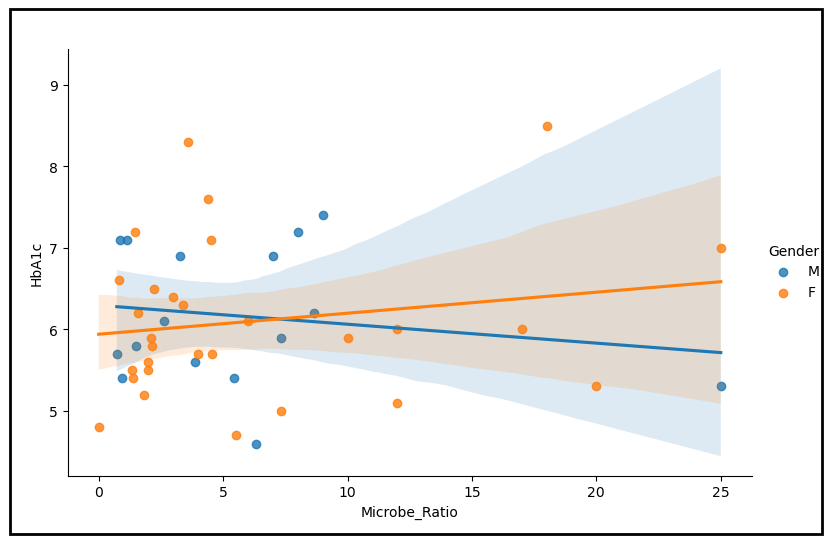

In [377]:
# Scotter plot chart for HbA1c vs Good Microbes Count
from matplotlib.patches import Rectangle
df = bioGutMicrobeData_df.copy()
df['Microbe_Ratio'] = df['Good_Microbes_Count'] / (df['Bad_Microbes_Count'] + 1)

sns.lmplot(data=df, x='Microbe_Ratio', y='HbA1c', hue='Gender', aspect=1.5, )
fig = plt.gcf()

# Add a border around the entire figure (page frame)
fig.patches.append(
    Rectangle(
        (0, 0), 1,1.05, transform=fig.transFigure,
        fill=False, color='black', linewidth=2
    )
)
plt.show()

#### <b> Radial Chart for Average Gut Function

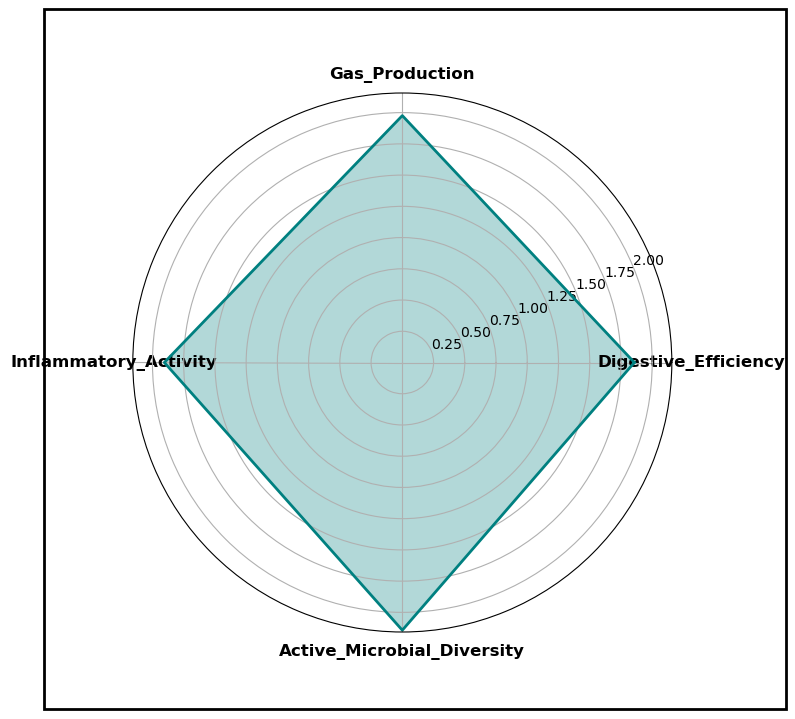

In [379]:
# Radial Chart for Average Gut Function
features = ['Digestive_Efficiency', 'Gas_Production', 'Inflammatory_Activity', 'Active_Microbial_Diversity']
mean_vals = df[features].mean()


angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
stats = mean_vals.tolist()
stats += stats[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
ax.plot(angles, stats, color='teal', linewidth=2)
ax.fill(angles, stats, color='teal', alpha=0.3)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, fontsize=12, fontweight='bold')
fig = plt.gcf()
fig.patches.append(
    Rectangle(
        (0, 0), 1.06,1, transform=fig.transFigure,
        fill=False, color='black', linewidth=2
    )
)
plt.show()

#### <b> Health Matrix for macros for all the participants

/var/folders/y8/wl0vplw514vc9f2mdztfqdrr0000gn/T/ipykernel_80155/771080406.py:98: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = pivot.replace(status_to_int)


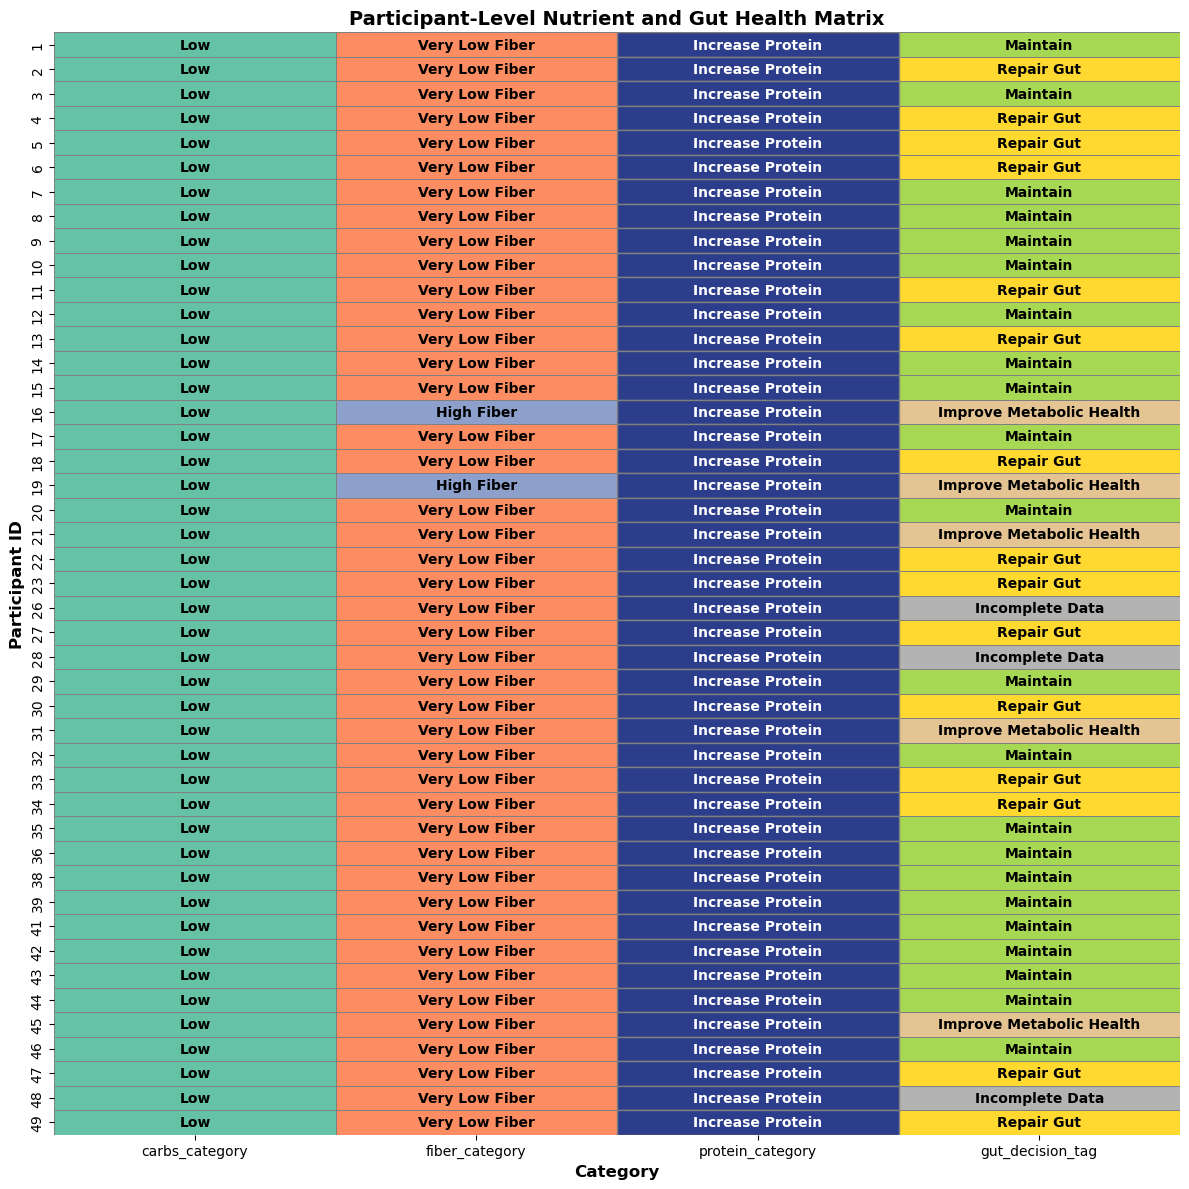

In [ ]:

# Make copies
df1 = cgmData_df.copy()
#Clean column names
df1.columns = df1.columns.str.strip().str.lower().str.replace(" ", "_")
df2.columns = df2.columns.str.strip().str.lower().str.replace(" ", "_")

# Aggregate average macronutrients by participant
nutrients = ['carbs', 'protein', 'fiber']
nutrient_avg = df1.groupby('participantid')[nutrients].mean().reset_index()

#  Define categorization functions
def categorize_carbs(x):
    if pd.isnull(x):
        return "No Data"
    elif x < 100:
        return "Low"
    elif x < 250:
        return "Moderate"
    else:
        return "High"

def categorize_protein(x):
    if pd.isnull(x):
        return "No Data"
    elif x < 50:
        return "Increase Protein"
    elif x < 80:
        return "Normal Protein OK"
    else:
        return "Reduce Protein"

def categorize_fiber(x):
    if pd.isnull(x):
        return "No Data"
    elif x < 15:
        return "Very Low Fiber"
    elif x < 25:
        return "Moderate Fiber"
    else:
        return "High Fiber"

# Apply categorization
nutrient_avg["carbs_category"] = nutrient_avg["carbs"].apply(categorize_carbs)
nutrient_avg["protein_category"] = nutrient_avg["protein"].apply(categorize_protein)
nutrient_avg["fiber_category"] = nutrient_avg["fiber"].apply(categorize_fiber)

# STEP 6: Merge with gut & metabolic scores
merged_df = pd.merge(
    nutrient_avg,
    df2[['participantid', 'gut_lining_health', 'metabolic_fitness']],
    on='participantid',
    how='left'
)

# Gut health decision logic
def decision_tag(row):
    if pd.isnull(row["gut_lining_health"]) or pd.isnull(row["metabolic_fitness"]):
        return "Incomplete Data"
    elif row["gut_lining_health"] < 2:
        return "Repair Gut"
    elif row["metabolic_fitness"] < 2:
        return "Improve Metabolic Health"
    else:
        return "Maintain"

merged_df["gut_decision_tag"] = merged_df.apply(decision_tag, axis=1)

# Final matrix with desired column order
decision_matrix = merged_df[[
    "participantid",
    "carbs_category",
    "fiber_category",
    "protein_category",
    "gut_decision_tag"
]].sort_values("participantid")

# Melt for heatmap
melted_df = decision_matrix.melt(
    id_vars='participantid', 
    value_vars=['carbs_category', 'fiber_category', 'protein_category', 'gut_decision_tag'],
    var_name='Category', 
    value_name='Status'
)

# Pivot and encode
category_order = ['carbs_category', 'fiber_category', 'protein_category', 'gut_decision_tag']
pivot = melted_df.pivot(index='participantid', columns='Category', values='Status')
pivot = pivot[category_order]  # Enforce order

unique_status = melted_df['Status'].unique()
status_to_int = {status: i for i, status in enumerate(unique_status)}
heatmap_data = pivot.replace(status_to_int)

# Plot heatmap
plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    heatmap_data,
    annot=pivot,
    fmt='',
    cmap=sns.color_palette("Set2", len(unique_status)),
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    annot_kws={"weight": "bold"}
)

# Highlight protein_category column
protein_col_idx = list(pivot.columns).index('protein_category')
for (i, j), val in np.ndenumerate(heatmap_data.values):
    if j == protein_col_idx:
        ax.add_patch(
            patches.Rectangle((j, i), 1, 1, fill=True, color="#2B3D8B", ec='gray')
        )

#  White font for protein, black elsewhere
for text in ax.texts:
    col_idx = int(text.get_position()[0] - 0.5)
    if col_idx == protein_col_idx:
        text.set_color("white")
    else:
        text.set_color("black")

#  Final polish
plt.xlabel("Category", fontsize=12, weight='bold')
plt.ylabel("Participant ID", fontsize=12, weight='bold')
plt.title("Participant-Level Nutrient and Gut Health Matrix", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()
